Imports and Helper Functions

In [1]:
import os
import shutil
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random, os
from PIL import Image


# Load mean and std values from the JSON file
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = mean_std['mean']
std = mean_std['std']

# Define the VGG-16 model with frozen pretrained weights
def get_vgg16_model(num_classes):
    model = models.vgg16(pretrained=True)
    
    # Freeze all the weights
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last layer with a new one (unfrozen) for our specific number of classes
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model

# Define a transform that includes normalization with the previously computed mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Training and Evaluation Functions

In [2]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc * 100:.4f} - '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            running_loss += loss.item() * inputs.size(0)

    loss = running_loss / len(dataloader.dataset)
    accuracy = corrects.double() / len(dataloader.dataset)
    return loss, accuracy


Training and Model Saving

In [3]:
# Base directory containing the k-fold datasets
base_dir = 'dataset_kfold'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')
    
    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_dataset = ImageFolder(root=train_dir, transform=transform)
    val_dataset = ImageFolder(root=val_dir, transform=transform)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False, num_workers=4)

    # Get the model and move it to the appropriate device
    num_classes = len(train_dataset.classes)
    model = get_vgg16_model(num_classes).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)  # Only optimize the unfrozen layer

    # Train and evaluate the model
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)
    
    # Save the model for this fold
    model_path = f'vgg16_fold_{fold}.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)
    
    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    fold_accuracies.append(val_acc.item())
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')

Starting training for fold 0...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train loss: 1.5117, Train accuracy: 22.6562 - Val loss: 1.3381, Val accuracy: 35.4167
Epoch 2/10 - Train loss: 1.3613, Train accuracy: 35.4167 - Val loss: 1.2361, Val accuracy: 53.1250
Epoch 3/10 - Train loss: 1.2812, Train accuracy: 40.6250 - Val loss: 1.1435, Val accuracy: 59.3750
Epoch 4/10 - Train loss: 1.2001, Train accuracy: 45.5729 - Val loss: 1.0687, Val accuracy: 62.5000
Epoch 5/10 - Train loss: 1.1129, Train accuracy: 54.6875 - Val loss: 1.0049, Val accuracy: 67.7083
Epoch 6/10 - Train loss: 1.0339, Train accuracy: 58.8542 - Val loss: 0.9485, Val accuracy: 73.9583
Epoch 7/10 - Train loss: 1.0038, Train accuracy: 57.2917 - Val loss: 0.9052, Val accuracy: 76.0417
Epoch 8/10 - Train loss: 0.9260, Train accuracy: 64.8438 - Val loss: 0.8674, Val accuracy: 78.1250
Epoch 9/10 - Train loss: 0.8970, Train accuracy: 65.3646 - Val loss: 0.8351, Val accuracy: 77.0833
Epoch 10/10 - Train loss: 0.8756, Train accuracy: 67.4479 - Val loss: 0.8075, Val accuracy: 77.0833
Model for

Confuse Matrix and Classification Report for each fold

Loading model for fold 0...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


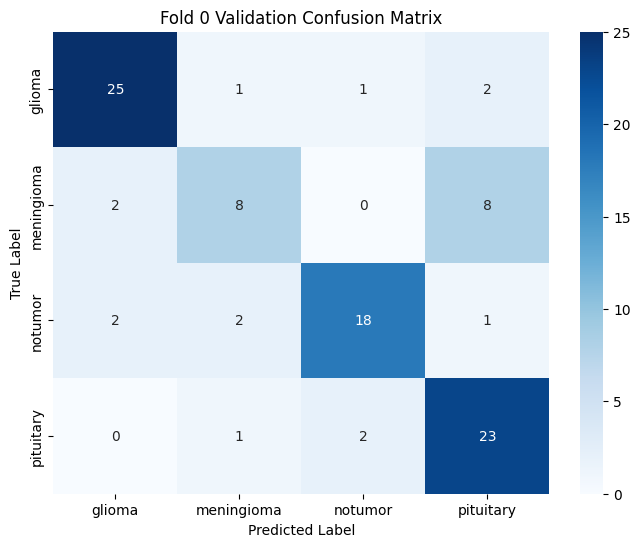

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.86      0.86      0.86        29
  meningioma       0.67      0.44      0.53        18
     notumor       0.86      0.78      0.82        23
   pituitary       0.68      0.88      0.77        26

    accuracy                           0.77        96
   macro avg       0.77      0.74      0.75        96
weighted avg       0.77      0.77      0.76        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 25, TN: 63, FP: 4, FN: 4
Class: meningioma, TP: 8, TN: 74, FP: 4, FN: 10
Class: notumor, TP: 18, TN: 70, FP: 3, FN: 5
Class: pituitary, TP: 23, TN: 59, FP: 11, FN: 3
Loading model for fold 1...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


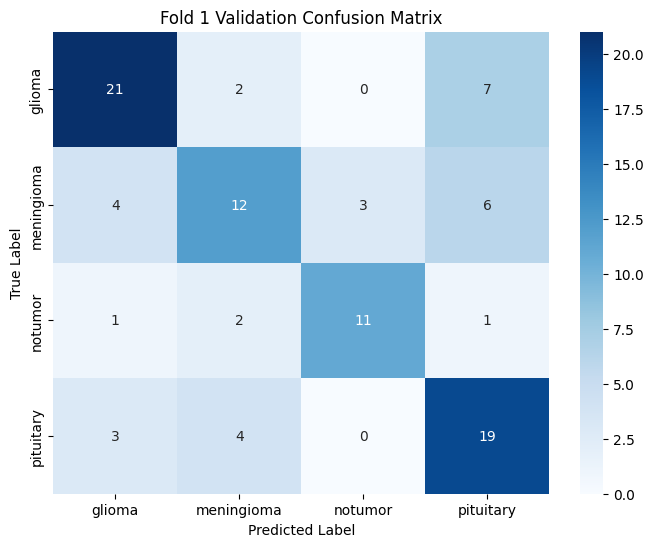

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.72      0.70      0.71        30
  meningioma       0.60      0.48      0.53        25
     notumor       0.79      0.73      0.76        15
   pituitary       0.58      0.73      0.64        26

    accuracy                           0.66        96
   macro avg       0.67      0.66      0.66        96
weighted avg       0.66      0.66      0.65        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 21, TN: 58, FP: 8, FN: 9
Class: meningioma, TP: 12, TN: 63, FP: 8, FN: 13
Class: notumor, TP: 11, TN: 78, FP: 3, FN: 4
Class: pituitary, TP: 19, TN: 56, FP: 14, FN: 7
Loading model for fold 2...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


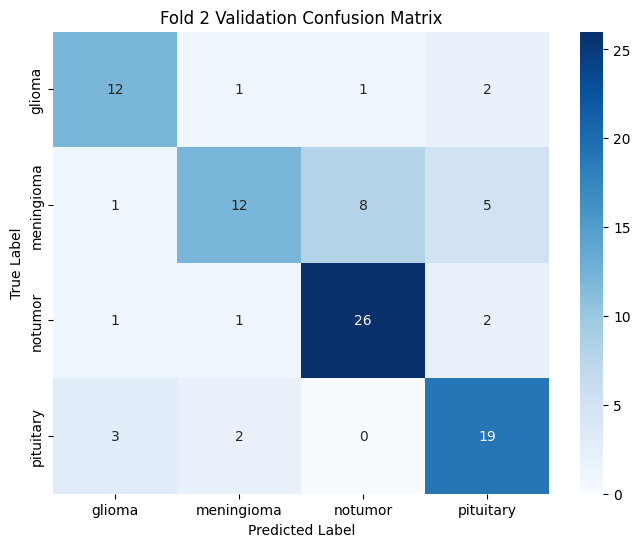

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.71      0.75      0.73        16
  meningioma       0.75      0.46      0.57        26
     notumor       0.74      0.87      0.80        30
   pituitary       0.68      0.79      0.73        24

    accuracy                           0.72        96
   macro avg       0.72      0.72      0.71        96
weighted avg       0.72      0.72      0.71        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 12, TN: 75, FP: 5, FN: 4
Class: meningioma, TP: 12, TN: 66, FP: 4, FN: 14
Class: notumor, TP: 26, TN: 57, FP: 9, FN: 4
Class: pituitary, TP: 19, TN: 63, FP: 9, FN: 5
Loading model for fold 3...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


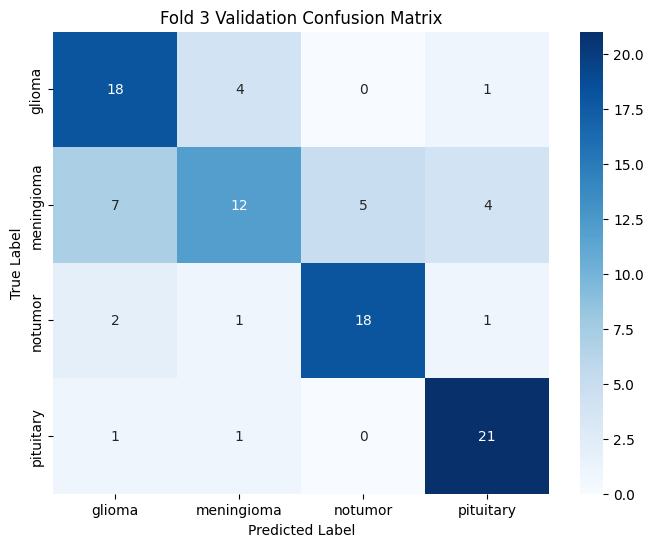

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.64      0.78      0.71        23
  meningioma       0.67      0.43      0.52        28
     notumor       0.78      0.82      0.80        22
   pituitary       0.78      0.91      0.84        23

    accuracy                           0.72        96
   macro avg       0.72      0.74      0.72        96
weighted avg       0.71      0.72      0.71        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 18, TN: 63, FP: 10, FN: 5
Class: meningioma, TP: 12, TN: 62, FP: 6, FN: 16
Class: notumor, TP: 18, TN: 69, FP: 5, FN: 4
Class: pituitary, TP: 21, TN: 67, FP: 6, FN: 2
Loading model for fold 4...


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


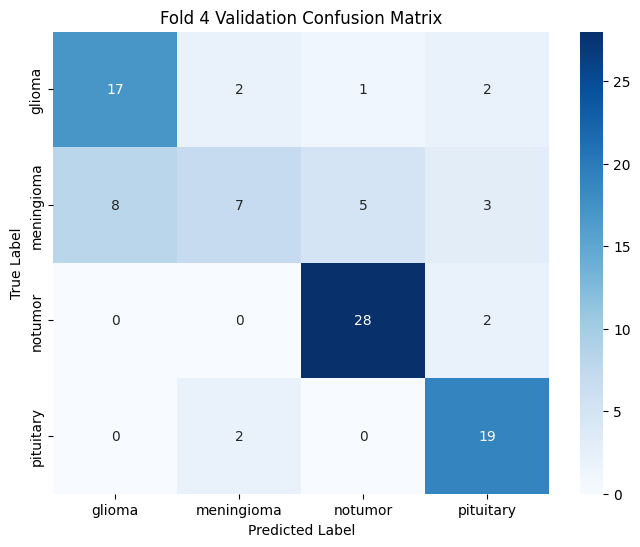

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.68      0.77      0.72        22
  meningioma       0.64      0.30      0.41        23
     notumor       0.82      0.93      0.88        30
   pituitary       0.73      0.90      0.81        21

    accuracy                           0.74        96
   macro avg       0.72      0.73      0.70        96
weighted avg       0.73      0.74      0.71        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 17, TN: 66, FP: 8, FN: 5
Class: meningioma, TP: 7, TN: 69, FP: 4, FN: 16
Class: notumor, TP: 28, TN: 60, FP: 6, FN: 2
Class: pituitary, TP: 19, TN: 68, FP: 7, FN: 2


In [13]:
# Define the function to load the model for inference
def load_model_for_inference(model_path, num_classes):
    model = get_vgg16_model(num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Loop through each fold directory and load the corresponding model
for fold in range(5):
    print(f'Loading model for fold {fold}...')
    model_path = f'vgg16_fold_{fold}.pth'
    model = load_model_for_inference(model_path, num_classes=len(train_dataset.classes))

    # Load the validation dataset for the current fold
    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_dataset = ImageFolder(root=val_dir, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Make predictions on the validation data
    val_predictions = []
    val_true_classes = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_classes.extend(labels.numpy())

    # Compute the confusion matrix for this fold
    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions, target_names=val_dataset.classes))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = val_dataset.classes
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")


Plotting Results and Printing Fold Accuracies 

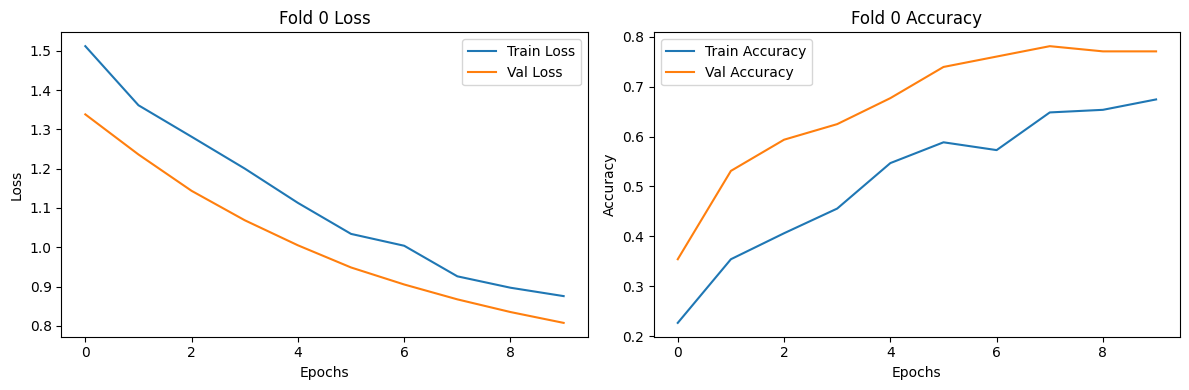

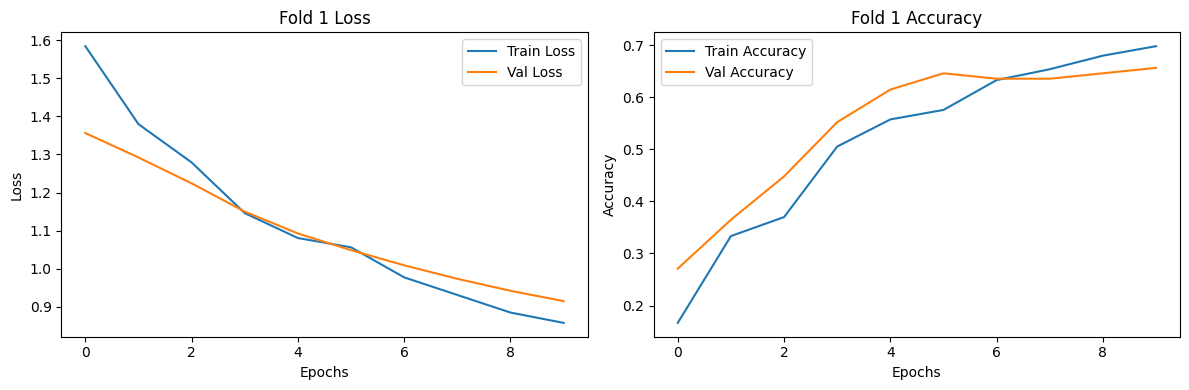

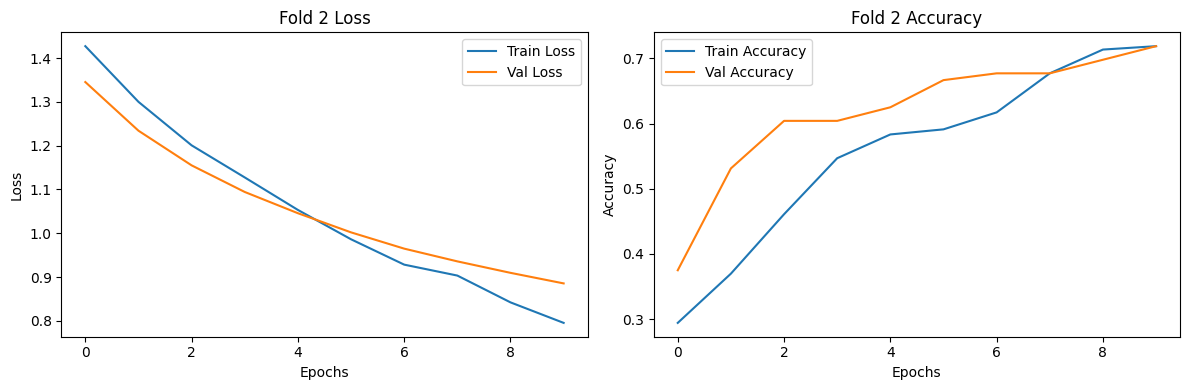

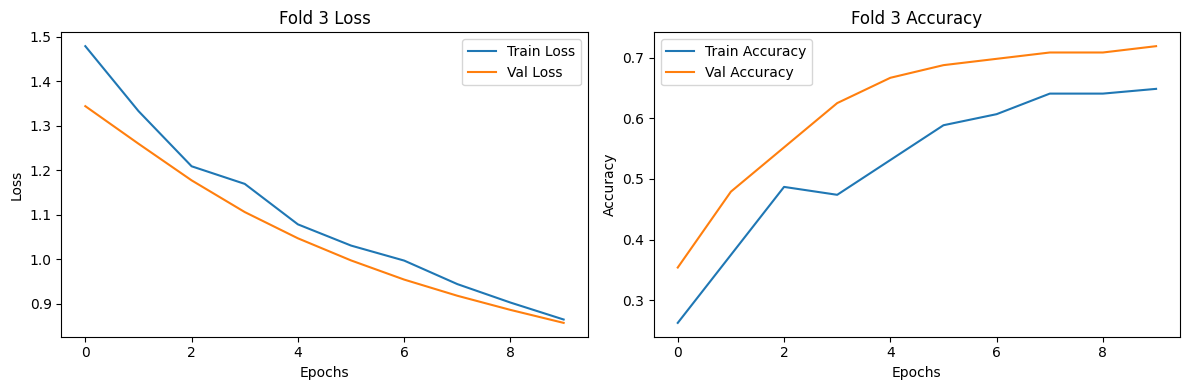

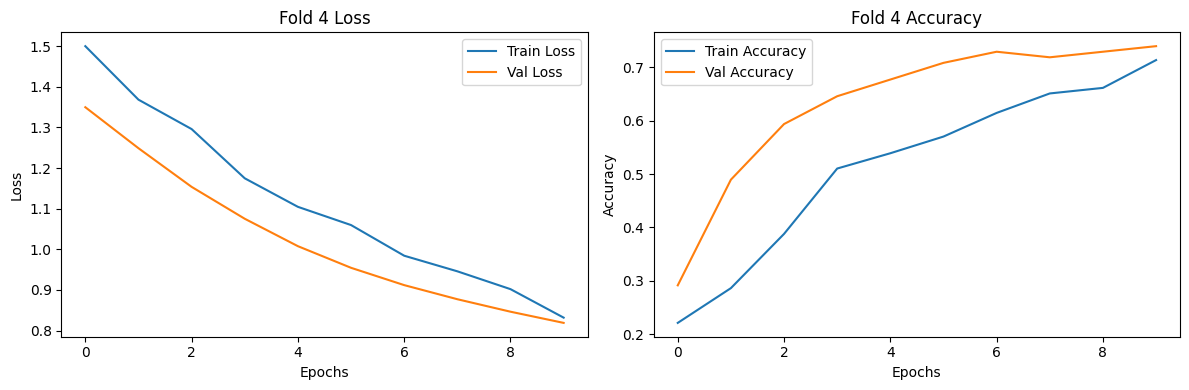

Accuracies for each fold:
Fold 0: 77.08%
Fold 1: 65.62%
Fold 2: 71.88%
Fold 3: 71.88%
Fold 4: 73.96%


In [5]:
 # Plot results
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Train Loss')
        plt.plot(all_val_losses[fold], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Train Accuracy')
        plt.plot(all_val_accuracies[fold], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")


Predicting a Random Image

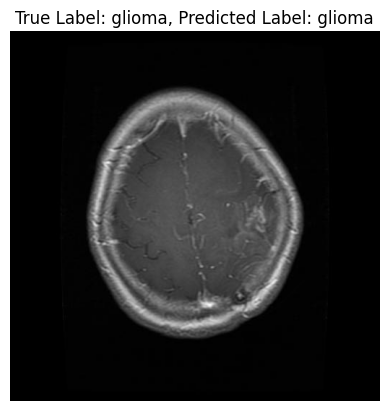

True Label: glioma
Predicted Label: glioma


In [12]:
# Define a function to predict the class of a single image
def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return predicted.item()

# Predict a random image from the dataset
random_image_path, _ = random.choice(val_dataset.samples)
predicted_class = predict_image(random_image_path, model, transform)

# Extract the true label
true_label_name = os.path.basename(os.path.dirname(random_image_path))
true_label_idx = val_dataset.class_to_idx[true_label_name]

# Load the image for display
image = Image.open(random_image_path)
plt.imshow(image)
plt.title(f'True Label: {val_dataset.classes[true_label_idx]}, Predicted Label: {val_dataset.classes[predicted_class]}')
plt.axis('off')
plt.show()

# Print true and predicted labels
print(f'True Label: {val_dataset.classes[true_label_idx]}')
print(f'Predicted Label: {val_dataset.classes[predicted_class]}')
